## IMPORTANT POINT BEFORE RUNNING
1. This project is an Image Classifier and uses approximately 15000 images for training purposes. Full datasets of the images are NOT uploaded.  The images can be downloaded from this link.
- *https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LQUWXW*
- *https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/GDON8Q*

2.  Please download the images (with appropriate credit to academic source ) and group them into the folders as created in the data folders,`data_banana` and `data_maize` of this project. The folder structure is explained below and in comments along with the code at various places.

3. I have used Adobe Photoshop Bridge to view and classify the images for `Severity` of the diseases (High, Low) and placed them in respective folders for training.  You can use tools of your choice. FastStone is one such tool ***https://www.faststone.org/download.htm***. It is `FREE` and easy to use (Windows only).

4. For K-Fold validation training, you will have to merge all the images from `validation` folder to corresponding folder in `training` folder
 


## MOST IMPORTANT
The models were built using :
1. Windows 11 Home Edition
2. 32GB System RAM
3. NVidia 4070 GPU with 12GB VRAM.
4. Ananconda / Anaconda Navigator 2.6.4
5. TensorFlow 2.10 (last version of TF that can run on Windows machine)
6. Python 3.10.13

Last, but **most** importantly, one will need `Patience`.  Depending on the hardware (laptop, desktop, cloud etc.) the training activities can take several hours. It takes about **7 - 8 hours** with the above hardware specs in total to run one complete cycle the three notebooks.

Happy Coding!

# Modeling Methodology <a id="top"></a>
This notebook focuses primarily on building a `Image Classifier Model` for detecting diseases in `Banana` and `Maize` crops using Neural Network algorithms.  The models will be built using :
1. `Keras Sequential` :  It allows users to create a linear stack of neural network layers. This is useful for building simple baseline models and study its performance `metrics`.
2. `MobileNetV2`: MobileNetV2, on the other hand, is a pre-trained convolutional neural network (CNN) architecture designed for mobile and embedded vision applications. It's a more complex model, optimized for low latency and low computational requirements.

## Import necessary Libraries  <a id="1"></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import shutil

from datetime import datetime
import json

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

print('Imports Done!')


Imports Done!


## Check if the GPU is up and running  <a class="anchor" id="gpu"></a>
GPU should be running and configured to so Tensorflow can `use GPU` for modeling tasks in  the notebook tasks

In [3]:
#Check if GPU is available and configured to work with Tensorflow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    print("TensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("GPU is not available. TensorFlow is using the CPU.")

GPU is available
TensorFlow is using the following GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Set up the Home directory for Crops <a class="anchor" id="basedir"></a>

Setup home directories for `crop specific` images of `High` and `Low` infection rates

Here we load the images of the diseased crop for use by the Neural Network during training of the model. The data has already been downloaded.
1. Banana is one of the crops that is chosen for disease detection. The diseases the model is trying to dectet is `a. Black Sigatoka` and `b. Fusarium Wilt (also known as Panama Wilt)`
The `Banana` dataset has following directory structure.
<pre style="font-size: 12.0pt; font-family: menlo, consolas, 'DejaVu Sans Mono', monospace; line-height: 2; letter-spacing: 1.0pt;" >
<b>data_banana</b>
|__ <b>train</b>     
|____ <b>bs_high</b> - (with `high` infection of Black Sigatoka)
|____ <b>bs_low</b>  - (with `low` infection of Black Sigatoka)
|____ <b>fw_high</b> - (with `high` infection of Fusarium Wilt)
|____ <b>fw_low</b> - (with `low` infection of Fusarium Wilt)
|____ <b>healthy</b> - (with Healthy images)
|__ <b>val</b>     
|____ <b>bs_high</b> - (with `high` infection of Black Sigatoka)
|____ <b>bs_low</b>  - (with `low` infection of Black Sigatoka)
|____ <b>fw_high</b> - (with `high` infection of Fusarium Wilt)
|____ <b>fw_low</b> - (with `low` infection of Fusarium Wilt)
|____ <b>healthy</b> - (with Healthy images)

</pre>

---

2. Maize is another crop chosen for disease detection. The two diseases in Maize are `a. Maize Lethal Necrosis` and `b. Maize Streak Virus`
<pre style="font-size: 12.0pt; font-family:menlo, consolas, 'DejaVu Sans Mono', monospace; line-height: 2; letter-spacing: 1.0pt;" >
<b>data_maize</b>
|__ <b>train</b>         
|____ <b>mln_high</b> - (with `high` infection of Maize Lethal Necrosis)
|____ <b>mln_low</b>  - (with `low` infection of Maize Lethal Necrosis)
|____ <b>msv_high</b> - (with `high` infection of Maize Streak Virus)
|____ <b>msv_low</b> - (with `low` infection of Maize Streak Virus)
|____ <b>healthy</b> - (with Healthy images)
|__ <b>val</b>         
|____ <b>mln_high</b> - (with `high` infection of Maize Lethal Necrosis)
|____ <b>mln_low</b>  - (with `low` infection of Maize Lethal Necrosis)
|____ <b>msv_high</b> - (with `high` infection of Maize Streak Virus)
|____ <b>msv_low</b> - (with `low` infection of Maize Streak Virus)
|____ <b>healthy</b> - (with Healthy images)
</pre>

The folder has been split into two folders "train" and "val" ***(Training = 80%, Validation = 20%)***

## Utility Functions <a id="4"></a>

Utility functions to :
1. Save Trained Models
2. Save History to JSON
3. Plot the Accuracy & Loss Curves and Save it

In [37]:
#--------------------------
# Save the model to disk,
# Model, modelname and folder are input parameters
#--------------------------
def save_trained_model(model, modelname, foldername):
    print(f"Saving {modelname}...")
    t = datetime.now()
    filename = t.strftime(f"{modelname}_%Y_%m_%d_%H_%M_%S")
    # Save in H5 file format
    export_path_keras = f"{foldername}/{filename}.h5"
    print(export_path_keras)
    model.save(export_path_keras)
    print(f"Model saved to {modelname}...")

#--------------------------
# Save the History objecto JSON file,
# model-history data, modelname and folder are input parameters
# history and parameters objects are saved in JSON file
#--------------------------
def save_history_to_json(mod_history, modelname,foldername):
    print(f"Saving {modelname} history and parameters...")
    history_dict = mod_history.history
    t = datetime.now()
    filename = t.strftime(f"{foldername}/{modelname}_%Y_%m_%d_%H_%M_%S_hist.json")
    # filename = f'data/savedmodels/{modelname}_hist.json'
    with open(filename, 'w') as f:
        json.dump(history_dict, f)

    print(f"Saved {modelname} history...")
    save_dict = {
        "history": mod_history.history,
        "params": mod_history.params
    }
    # filename = 'data/savedmodels/{modelname}_hist_and_params.json'
    filename = t.strftime(f"{foldername}/{modelname}_%Y_%m_%d_%H_%M_%S_hist_and_params.json")
    with open(filename, 'w') as f:
        json.dump(save_dict, f)
    print(f"Saved {modelname} history and parameters...")

#--------------------------
# Save the Plot along with Model Performances
# model, modelname and foldername are parameters
# file is saved as JPG image
#--------------------------
def plot_model_performance_curve(modelname, model_hist, foldername):
    acc = model_hist.history['accuracy']
    val_acc = model_hist.history['val_accuracy']

    loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.suptitle(modelname)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    t = datetime.now()
    filename = t.strftime(f"{foldername}/{modelname}_perf_plot_%Y_%m_%d_%H_%M_%S.png")
    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.show()

#Plot the confusion Matrix in a heatmap with values of predictions
def plot_confusion_matrix(cm, class_names, title='Confusion matrix'):
    fig = plt.figure(figsize=(7,4))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="g",cmap=plt.cm.Blues)
    ax.set_xlabel('Predicted Label', fontsize=15)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=45)
    ax.xaxis.set_ticklabels(class_names, fontsize = 12)
    ax.xaxis.tick_bottom()
    
    ax.set_ylabel('True Label', fontsize=15)
    ax.yaxis.set_ticklabels(class_names, fontsize = 12)
    plt.yticks(rotation=0)    
    plt.title(f'Confusion Matrix - {title}', fontsize=16)
    plt.savefig(f'images//{title.lower()}.png', bbox_inches='tight', dpi=120)


## Modeling-BANANA <a id="5"></a>
**Classify Black Sigatoka, Fusarium Wilt and Healthy**: Here the model will try to identify the `Severity` of the infection, i.e. whether it is `HIGH` or `LOW` for both infections of `Black Sigatoka`, `Fusarium Wilt` or `Healthy`


### Split data into Training and Validation sets <a id="51"></a>

In [38]:
# This function splits the images in to test and validation sets
# It is used only ONCE during the initial splitting of the images into Training and Validation sets
def arn_train_test_split(img_dir = 'data',train_percent=0.8, classes = []):

    for cl in classes:
        img_path = os.path.join(img_dir, cl)
        # print(img_path)
        images = glob.glob(img_path + '/*.jpg')
        print("{}: {} Images".format(cl, len(images)))
        num_train = int(round(len(images)*train_percent))
        train, val = images[:num_train], images[num_train:]

        for t in train:
            path = os.path.join(img_dir, 'train', cl)
            if not os.path.exists(path):
                os.makedirs(path)
            shutil.move(t, path)

        for v in val:
            path = os.path.join(img_dir, 'val', cl)
            if not os.path.exists(path):
                os.makedirs(path)
            shutil.move(v, path)

        print('Test data split to Train and Validation Datasets', )


### Model Configurations - Banana <a id="52"></a>
Configure Image folders to train, output classes, model parameters

In [39]:
# Directories to build Banana Model
# base directory, training and validation folders for `banana` images output `Classses` are configured
base_dir_ban = 'data_banana'
train_dir_ban = os.path.join(base_dir_ban, 'train')
validation_dir_ban = os.path.join(base_dir_ban, 'val')
print(base_dir_ban)
print(train_dir_ban)
print(validation_dir_ban)

# These are the classes of banana images and are used as output classes
classes_ban = ['bs_high', 'bs_low', 'fw_high', 'fw_low','healthy']
print(classes_ban)

# Setup Model Parameters
# Number of training examples to process before updating our models variables
# The training data consists of images with width of 150 pixels and height of 150 pixels
BATCH_SIZE = 32
IMG_SHAPE  = 150

data_banana
data_banana\train
data_banana\val
['bs_high', 'bs_low', 'fw_high', 'fw_low', 'healthy']


In [40]:
# Split the BANANA data into training and validation data sets.
####
# UNCOMMENT THIS LINE ONLY IF IMAGES NEED TO BE SPLIT AGAIN
####
# arn_train_test_split(img_dir=base_dir_ban, train_percent=0.8, classes=classes_ban)

### Data Pre-Processing & Load the images  <a id="53"></a>
Images must be formatted into appropriately pre-processed and `ImageDataGenerator` produces batches of real-time enhanced tensor image data, before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into tensor image data
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

These tasks can be done using the class **`tf.keras.preprocessing.image.ImageDataGenerator`**.

**Data Augmentation**
Images are augmented with following image transformations
1. Rotation = 45 degree
2. Horizontal Flip
3. Zoom range = 0.3
4. Width & Height shift = 0.15
5. Shear Range = 0.2

In [41]:
# Generator for our training data
# Images are augmented with following image transformations
# 1. Rotation = 45 degree
# 2. Horizontal Flip
# 3. Zoom range = 0.3
# 4. Width & Height shift = 0.15
# 5. Shear Range = 0.2

train_img_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15
                                  )
train_data_gen = train_img_gen.flow_from_directory(
                                                    batch_size=BATCH_SIZE,
                                                    directory=train_dir_ban,
                                                    shuffle=True,
                                                    target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                    class_mode='categorical'
                                                    )

# Generator for our validation data
# No transformation only rescaling the images
val_img_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = val_img_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=validation_dir_ban,
                                              shuffle=False,
                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                              class_mode='categorical')


Found 6447 images belonging to 5 classes.
Found 1611 images belonging to 5 classes.


### Setup Sequential Neural Netrwork model  <a id="54"></a>

The model consists of `**THREE**` convolution blocks with a `max pool layer` in each of them. Then we have a fully connected layer with 128 units, with a `relu` activation function. The model will output class probabilities for **`FIVE`** classes using `softmax`
1. `Black Sigatoka-High Infection`
2. `Black Sigatoka-Low Infection`
3. `Fusarium Wilt-High Infection`
4. `Fusarium Wilt-Low Infection` and finally,
5. `Healthy`

In [42]:
# -----------------------------
# Setup the Sequential neural network as Base Model
# 3 Conv2D layers blocks and a MaxPooling Layer for each
# Flatten and Dropout layers
# finally output layer with 5 classes
# -----------------------------
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

### Compile and Train the model <a id="55"></a>

`Adam` optimizer will be used. As `softmax` is used for final layer on deciding the disease class,  `CategoricalCrossentropy` will be used as the loss function.
It will be good idea to track the training and validation accuracy on each epoch as we train our network, so we are passing `accuracy`, `Precision`, `Recall` in the metrics argument.

We can evaluate the performances of Model later by saving the metrics to the local disk


In [65]:
# Compile the model, with Adam optimizer, with 'accuracy', 'precision' and 'recall' as metrics
# CategoricalCrossEntropy is the Loss function

base_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# The number of epochs to train
epochs = 30
# Train the BASE MODEL
history = base_model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // BATCH_SIZE,
    verbose=0
)


### Save Sequential Model to disk - BANANA <a id="56"></a>

Saving Baseline-Sequential...
data_banana\savedmodels/Baseline-Sequential_2025_03_18_04_13_58.h5
Model saved to Baseline-Sequential...
Saving Baseline-Sequential history and parameters...
Saved Baseline-Sequential history...
Saved Baseline-Sequential history and parameters...


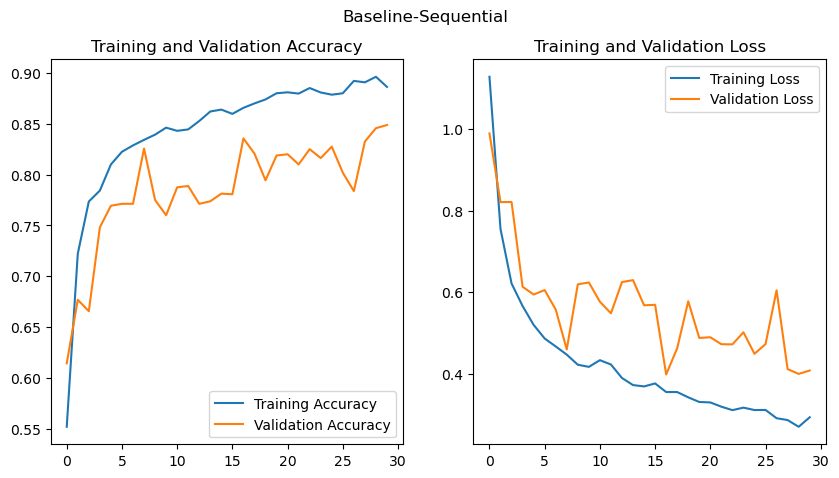

In [10]:
foldername = os.path.join(base_dir_ban, 'savedmodels')
#save the model
save_trained_model(base_model,'Baseline-Sequential', foldername)
# save the history JSON
save_history_to_json(history,'Baseline-Sequential',foldername)
# plot the metrics
plot_model_performance_curve('Baseline-Sequential', history, foldername)

### Evaluation Metrics of Baseline Banana Model
<table>
<tr><td>Metrics</td><td>Training Average</td><td>Validation Average</td></tr>
<tr><td>Loss</td><td>38.6%</td><td>58.5%</td></tr>
<tr><td>Accuracy</td><td>83.1%</td><td>78.9%</td></tr> 
<tr><td>Precision (precision_1)</td><td>88.2%</td><td>81.2%</td></tr>
<tr><td>Recall (recall_1)</td><td>80.3%</td><td>74.3%</td></tr>
<tr><td>F1 Score</td><td>84.1%</td><td>77.6%</td></tr>
</table>


### Test the BANANA Model with sample images <a id="57"></a>

In [68]:
# -------------------------
# path to test images
# Setup BANANA Test Image Generator
# -------------------------
test_img_path = 'data_banana\\banana_test'
# Generator for our testing data, batch = 1 so one image at a time can be tested.
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                                              test_img_path,
                                              batch_size=1,
                                              shuffle=False,
                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                              class_mode=None)


Found 42 images belonging to 5 classes.


In [69]:
# -------------------------
# Predict output probabilities for the test images
# -------------------------

probabilities = base_model.predict(test_generator)
# Get predicted class indices
predicted_class_indices = np.argmax(probabilities, axis=1)


42/42 [==============================] - 0s 4ms/step


In [70]:
# -------------------------
# Process the results
# Map indices back to string labels
# {0: 'bs_high', 1: 'bs_low', 2: 'fw_high', 3: 'fw_low', 4: 'healthy'}
# bs = Black Sigatoka, fw = Fusariam Wilt.
# -------------------------
class_mapping = {v: k for k, v in train_data_gen.class_indices.items()}

# get the predicted results from the model
predicted_labels = [class_mapping[idx] for idx in predicted_class_indices]

#the actual classes
true_class_indices = test_generator.classes
true_class_labels = [class_mapping[i] for i in true_class_indices]
# correct predictions
correct_indices = np.where(predicted_class_indices == true_class_indices)[0]
correct_labels = [class_mapping[predicted_class_indices[i]] for i in correct_indices]
# incorrect classification
incorrect_indices = np.where(predicted_class_indices != true_class_indices)[0]
incorrect_labels = [class_mapping[true_class_indices[i]] for i in incorrect_indices]

# Save results to CSV
results = pd.DataFrame({
    'Image Path': test_generator.filepaths,
    'Predicted Label': predicted_labels,
    'Actual Label' : true_class_labels
})
results.to_csv(f'{test_img_path}/predictions_ban_{datetime.now().strftime("%y%m%d%H%M%S")}.csv', index=False)

### Visualize the results - Correct Predictions <a id="58"></a>

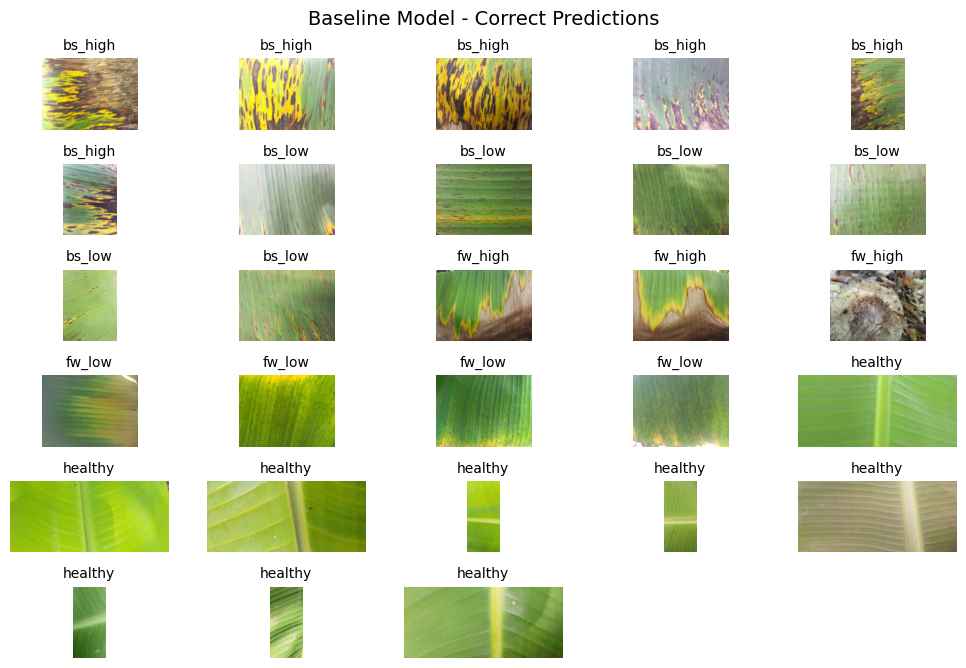

In [71]:
# Visualize results
# Show correct predictions
plt.figure(figsize=(10, 10))
for i in range(min(len(test_generator.filepaths), len(correct_indices))):
    plt.subplot(9, 5, i + 1)
    file_index = correct_indices[i]
    img = plt.imread(test_generator.filepaths[file_index])
    plt.imshow(img)
    plt.title(f"{correct_labels[i]}", fontsize=10)
    plt.axis('off')

plt.suptitle('Baseline Model - Correct Predictions', fontsize=14)
plt.tight_layout()
filename = f"{test_img_path}/baseline_model_correct_preds.png"
plt.savefig(filename, bbox_inches='tight', dpi=200)
plt.show()

### Visualize the results - Incorrect Predictions <a id="59"></a>

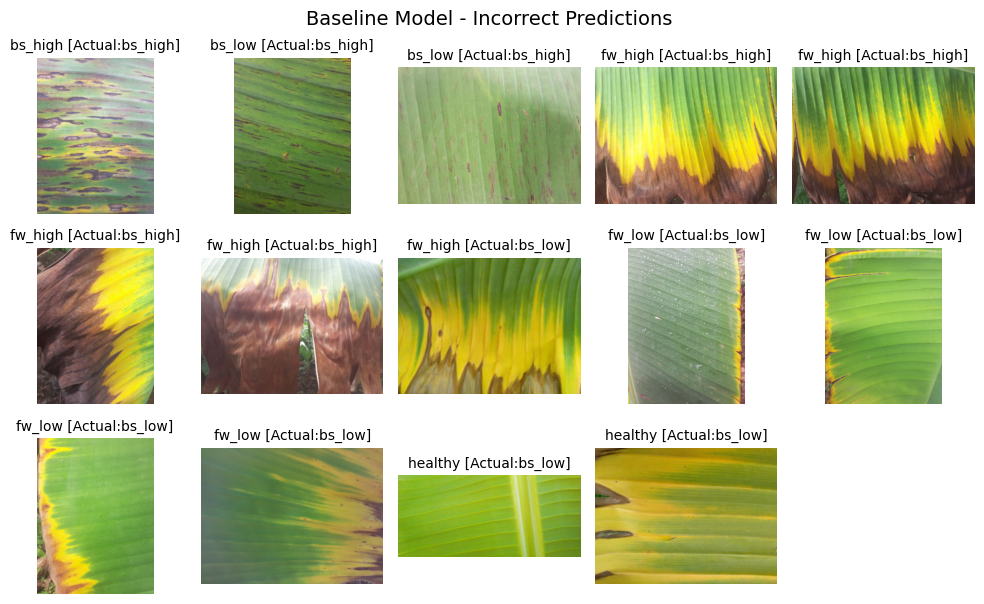

In [72]:
# Visualize results
# Show INCORRECT predictions
plt.figure(figsize=(10, 10))
for i in range(min(len(test_generator.filepaths), len(incorrect_indices))):
    plt.subplot(5, 5, i + 1)
    file_index = incorrect_indices[i]
    img = plt.imread(test_generator.filepaths[file_index])
    plt.imshow(img)
    plt.title(f"{incorrect_labels[i]} [Actual:{true_class_labels[i]}]", fontsize=10)
    plt.axis('off')

plt.suptitle('Baseline Model - Incorrect Predictions', fontsize=14)
plt.tight_layout()
filename = f"{test_img_path}/cnn_model_incorrect_preds.png"
plt.savefig(filename, bbox_inches='tight', dpi=200)
plt.show()

---

## Model Maize <a id="6"></a>
**Classify Maize Lethal Necrosis, Maize Streak Virus and Healthy** : Here the model will try to identify the `Severity` of the infection, i.e whether it is `HIGH` or `LOW` for both infections of `Lethal Necrosis`and `Maize Streak Virus`OR `Healthy`


### Model Configurations - Maize <a id="61"></a>
Configure Image folders to train, output classes, model parameters

In [54]:
# -----------------------
# base directory, training and validation folders for `maize` images
# -----------------------
base_dir_mz = 'data_maize'
train_dir_mz = os.path.join(base_dir_mz, 'train')
validation_dir_mz = os.path.join(base_dir_mz, 'val')
print(base_dir_mz)
print(train_dir_mz)
print(validation_dir_mz)

# -----------------------
# These are the classes of maize images and are used as output classes
# -----------------------
classes_mz = ['mln_high', 'mln_low', 'msv_high', 'msv_low','healthy']
print(classes_mz)

data_maize
data_maize\train
data_maize\val
['mln_high', 'mln_low', 'msv_high', 'msv_low', 'healthy']


In [45]:
# Split the BANANA data into training and validation data sets.
####
# UNCOMMENT THIS LINE ONLY IF IMAGES NEED TO BE SPLIT AGAIN
####
# arn_train_test_split(img_dir=base_dir_mz, train_percent=0.8, classes=classes_mz)

### Data Pre-Processing & Load the images <a id="62"></a>
Images must be formatted into appropriately pre-processed and `ImageDataGenerator` produces batches of real-time enhanced tensor image data, before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into tensor image data
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

These tasks can be done using the class **`tf.keras.preprocessing.image.ImageDataGenerator`**.

**Data Augmentation**
Images are augmented with following image transformations
1. Rotation = 45 degree
2. Horizontal Flip
3. Zoom range = 0.3
4. Width & Height shift = 0.15
5. Shear Range = 0.2

In [59]:
# Maize Image Generator for our training data

train_img_gen_mz = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.3,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15
                                  )
train_data_gen_mz = train_img_gen_mz.flow_from_directory(
                                                    batch_size=BATCH_SIZE,
                                                    directory=train_dir_mz,
                                                    shuffle=True,
                                                    target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                    class_mode='categorical'
                                                    )

# Generator for our validation data
val_img_gen_mz = ImageDataGenerator(rescale=1./255)
val_data_gen_mz = val_img_gen_mz.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=validation_dir_mz,
                                              shuffle=False,
                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                              class_mode='categorical')

Found 4871 images belonging to 5 classes.
Found 1213 images belonging to 5 classes.


### Setup Sequential Neural Netrowk model <a id="63"></a>

#### Use the same parameters as for `BANANA`
#### Only difference in MAIZE is the model is freshly trained with new `IMAGES` data of `MAIZE`
The model consists of `**THREE**` convolution blocks with a `max pool layer` in each of them. Then we have a fully connected layer with 128 units, with a `relu` activation function. The model will output class probabilities for **`FIVE`** classes using `softmax`
1. `Maize Lethal Necrosis-High Infection`
2. `Maize Lethal Necrosis-Low Infection`
3. `Maize Streak Virus-High Infection`
4. `Maize Streak Virus-Low Infection` and finally,
5. `Healthy`

In [60]:
# -----------------------------
# Setup the Sequential neural network as Base Model
# 3 Conv2D layers blocks and a MaxPooling Layer for each
# Flatten and Dropout layers
# finally output layer with 5 classes
# -----------------------------

base_model_mz = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

### Compile and Train the Maize model <a id="64"></a>

`Adam` optimizer will be used. As `softmax` is used for final layer on deciding the disease class,  `CategoricalCrossentropy` will be used as the loss function.
It will be good idea to track the training and validation accuracy on each epoch as we train our network, so we are passing `accuracy`, `Precision`, `Recall` in the metrics argument.

We can evaluate the performances of Model later by saving the metrics to the local disk

In [61]:
# Compile the model
base_model_mz.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# The number of epochs to train
epochs = 30

# Train the Base Model
history_mz = base_model_mz.fit(
    train_data_gen_mz,
    steps_per_epoch=train_data_gen_mz.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=val_data_gen_mz,
    validation_steps=val_data_gen_mz.samples // BATCH_SIZE,
    verbose=0
)

### Save Sequential Model to disk - MAIZE <a id="65"></a>

Saving Baseline-Sequential...
data_maize\savedmodels/Baseline-Sequential_2025_03_20_23_25_22.h5
Model saved to Baseline-Sequential...
Saving Baseline-Sequential history and parameters...
Saved Baseline-Sequential history...
Saved Baseline-Sequential history and parameters...


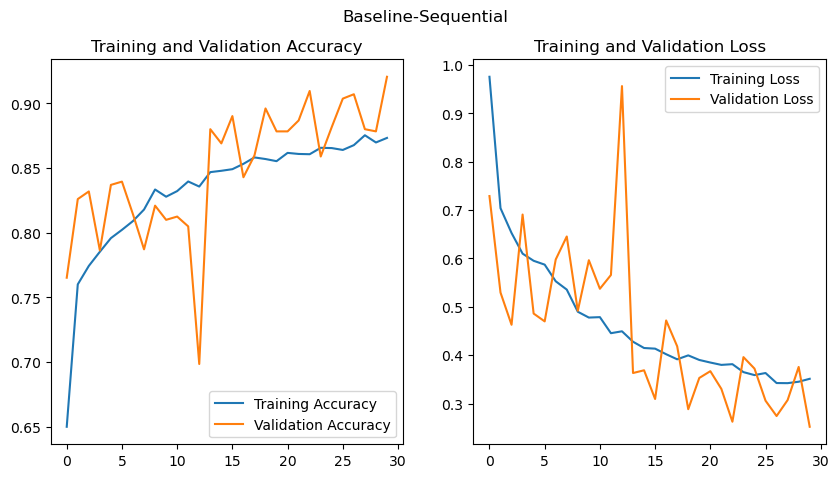

In [62]:
foldername = os.path.join(base_dir_mz, 'savedmodels')
#save the model
save_trained_model(base_model_mz,'Baseline-Sequential', foldername)
# save the history JSON
save_history_to_json(history_mz,'Baseline-Sequential',foldername)
# plot the metrics
plot_model_performance_curve('Baseline-Sequential', history_mz, foldername)

#### Evaluation Metrics of Baseline Maize Model 
<table>
<tr><td>Metrics</td><td>Training Average</td><td>Validation Average</td></tr>
<tr><td>Loss</td><td>52.0%</td><td>53.8%</td></tr>
<tr><td>Accuracy</td><td>78.4%</td><td>79.3%</td></tr>
<tr><td>Precision (precision_1)</td><td>84.6%</td><td>83.5%</td></tr>
<tr><td>Recall (recall_1)</td><td>76.0%</td><td>79.4%</td></tr>
<tr><td>F1 Score</td><td>80.1%</td><td>81.4%</td></tr>
</table>


### Test the MAIZE Model with sample images <a id="66"></a>

In [63]:
# -----------------------------
#path to test images
# Setup MAIZE Test Image Generator
# -----------------------------

test_img_path_mz = 'data_maize\\maize_test'
# Generator for our testing data, batch = 1 so one image at a time can be tested.
test_datagen_mz = ImageDataGenerator(rescale=1./255)
test_generator_mz = test_datagen_mz.flow_from_directory(
                                              test_img_path_mz,
                                              batch_size=1,
                                              shuffle=False,
                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                              class_mode=None)


Found 50 images belonging to 5 classes.


In [64]:
# -----------------------------
# Predict output probabilities for the test images
# -----------------------------

probabilities = base_model_mz.predict(test_generator_mz)
# Get predicted class indices
predicted_class_indices = np.argmax(probabilities, axis=1)


50/50 [==============================] - 0s 6ms/step


In [24]:
# ------------------------------------------
# Process the results
# Map indices back to string labels
# {0: 'mln_high', 1: 'mln_low', 2: 'msv_high', 3: 'msv_low', 4: 'healthy'}
# mln = Maize Lethal Necrosis, MSV = Maize Streak Virus.
# ------------------------------------------

class_mapping = {v: k for k, v in train_data_gen_mz.class_indices.items()}

# get the predicted results from the model
predicted_labels = [class_mapping[idx] for idx in predicted_class_indices]

#the actual classes
true_class_indices = test_generator_mz.classes
true_class_labels = [class_mapping[i] for i in true_class_indices]
# correct predictions
correct_indices = np.where(predicted_class_indices == true_class_indices)[0]
correct_labels = [class_mapping[predicted_class_indices[i]] for i in correct_indices]
# incorrect classification
incorrect_indices = np.where(predicted_class_indices != true_class_indices)[0]
incorrect_labels = [class_mapping[true_class_indices[i]] for i in incorrect_indices]

# Save results to CSV
results = pd.DataFrame({
    'Image Path': test_generator_mz.filepaths,
    'Predicted Label': predicted_labels,
    'Actual Label' : true_class_labels
})
results.to_csv(f'{test_img_path_mz}/predictions_mz_{datetime.now().strftime("%y%m%d%H%M%S")}.csv', index=False)


### Visualize the results - Correct Predictions <a id="67"></a>

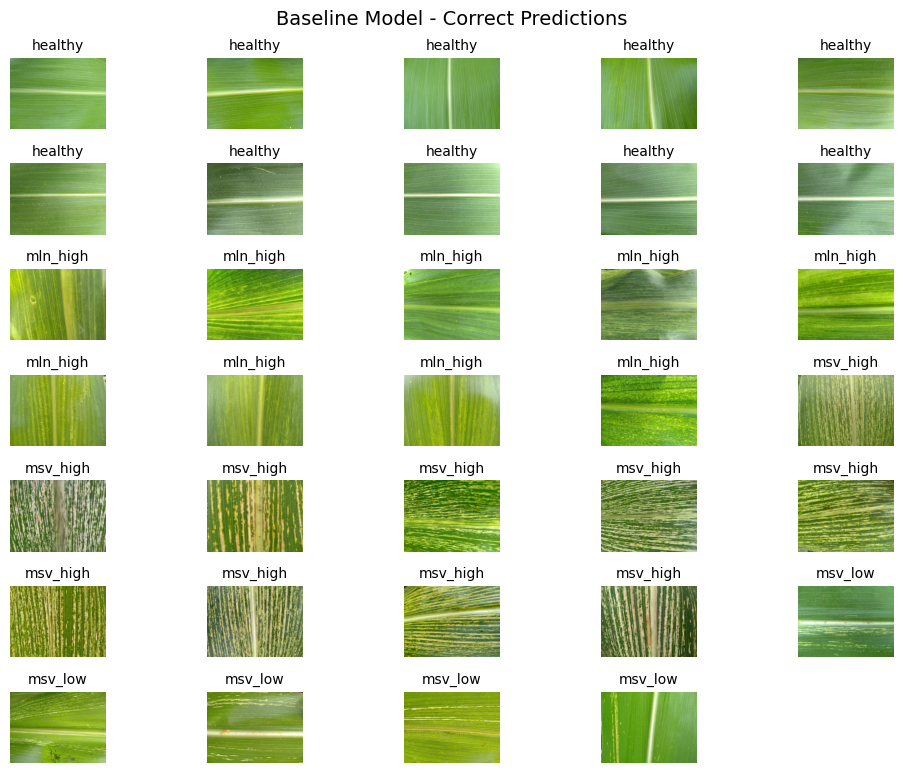

In [25]:
# -------------------------------------
# Visualize results
# Show correct predictions
# -------------------------------------

plt.figure(figsize=(10, 10))
for i in range(min(len(test_generator_mz.filepaths), len(correct_indices))):
    plt.subplot(9, 5, i + 1)
    file_index = correct_indices[i]
    img = plt.imread(test_generator_mz.filepaths[file_index])
    plt.imshow(img)
    plt.title(f"{correct_labels[i]}", fontsize=10)
    plt.axis('off')

plt.suptitle('Baseline Model - Correct Predictions', fontsize=14)
plt.tight_layout()
filename = f"{test_img_path_mz}/baseline_model_correct_preds.png"
plt.savefig(filename, bbox_inches='tight', dpi=200)
plt.show()

### Visualize the results - Incorrect Predictions <a id="68"></a>

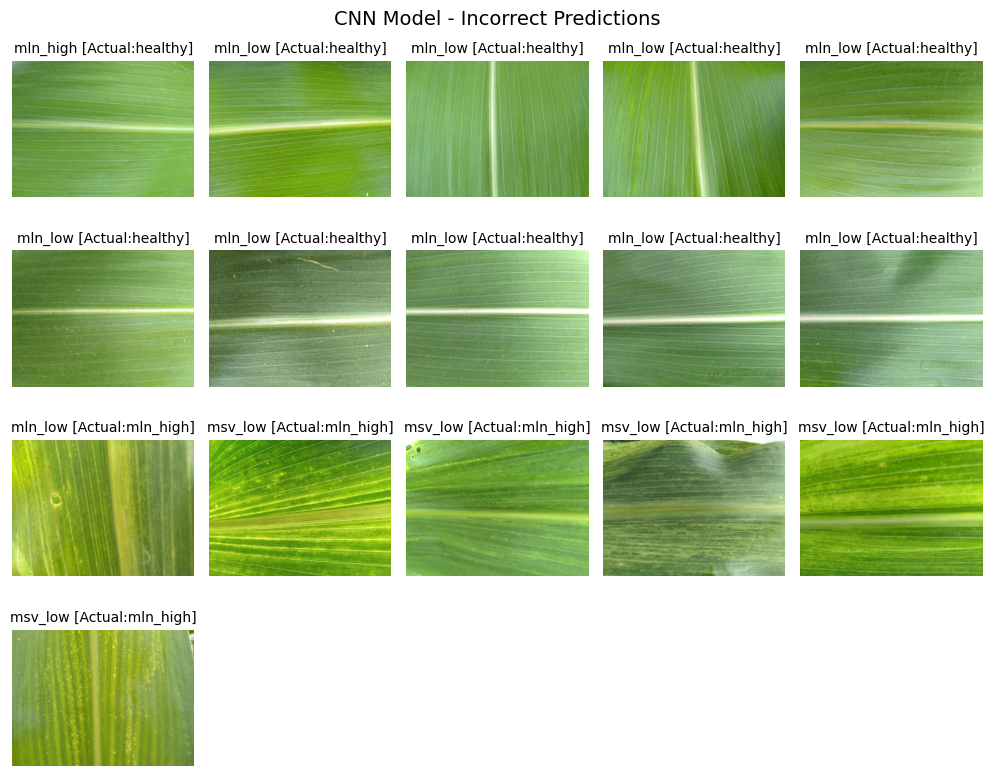

In [26]:
# -------------------------------------
# Visualize results
# Show INCORRECT predictions
# -------------------------------------
plt.figure(figsize=(10, 10))
for i in range(min(len(test_generator_mz.filepaths), len(incorrect_indices))):
    plt.subplot(5, 5, i + 1)
    file_index = correct_indices[i]
    img = plt.imread(test_generator_mz.filepaths[file_index])
    plt.imshow(img)
    plt.title(f"{incorrect_labels[i]} [Actual:{true_class_labels[i]}]", fontsize=10)
    plt.axis('off')


plt.suptitle('Baseline Model - Incorrect Predictions', fontsize=14)
plt.tight_layout()
filename = f"{test_img_path}/cnn_model_incorrect_preds.png"
plt.savefig(filename, bbox_inches='tight', dpi=200)
plt.show()

In [27]:
base_model_mz.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

## Train the dataset with MobileNetV2 and StratifiedKFold Cross Validation<a id="70"></a>
MobileNetV2 is an efficient convolutional neural network designed for mobile and embedded devices. This design enhances representational power while reducing computational costs.

MobileNetV2 is 30% smaller in terms of parameters and achieving 30-40% lower latency while improving accuracy. It is widely used in applications like object detection, semantic segmentation, and medical imaging, often matching or outperforming more complex models with significantly lower computational demands.

Pre-trained models are available in popular frameworks like TensorFlow and Keras, enabling easy fine-tuning and deployment on resource-constrained devices. Its lightweight and efficient architecture makes MobileNetV2 a go-to choice for real-time processing tasks on mobile and embedded platforms.

5 Fold Cross validation is used to improve the model performance


### Configure MobileNetV2 settings and parameters <a id="71"></a>

In [26]:
# -----------------------------
# Configuration - Banana and Maize for
# -----------------------------
epochs = 20
configs = [
    {
        'name': 'MobileNetV2-Maize',
        'model': MobileNetV2,
        'base_dir': 'data_maize\\data_kfold\\maize',       # Folder containing 5 subfolders (one per class)
        'input_shape': (224, 224, 3),          # Target input shape for MobileNetV2
        'batch_size': 32,
        'epochs': epochs,
        'savedmodels_dir':'data_maize\\data_kfold\\savedmodels_mz',
        'vis_layer': 'block_1_expand_relu'
    },
    {
        'name': 'MobileNetV2-Banana',
        'model': MobileNetV2,
        'base_dir': 'data_banana\\data_kfold\\banana',       # Folder containing 5 subfolders (one per class)
        'input_shape': (224, 224, 3),          # Target input shape for MobileNetV2
        'batch_size': 32,
        'epochs': epochs,
        'savedmodels_dir':'data_banana\\data_kfold\\savedmodels_ban',
        'vis_layer': 'block_1_expand_relu'
    }
]


In [27]:
# -----------------------------
# Build a DataFrame of all images
# -----------------------------
def build_dataframe(directory):
    data_list = []
    # Each subfolder in "directory" is a separate class
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(class_path, file)
                    data_list.append({'filename': file_path, 'class': class_name})
    return pd.DataFrame(data_list)


In [28]:
# -----------------------------
# Define ImageDataGenerators for augmentation and rescaling
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation, we only rescale
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [29]:
# -----------------------------
# Define a function to build the MobileNetV2 model
# -----------------------------
def build_kfold_model(config):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=config['input_shape'],
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # freeze the base model

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(5, activation='softmax')  # 5 classes
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

Total images found: 6067
                                            filename    class
0    data_maize\data_kfold\maize\healthy\Image_1.jpg  healthy
1   data_maize\data_kfold\maize\healthy\Image_10.jpg  healthy
2  data_maize\data_kfold\maize\healthy\Image_100.jpg  healthy
3  data_maize\data_kfold\maize\healthy\Image_1000...  healthy
4  data_maize\data_kfold\maize\healthy\Image_1001...  healthy


===== Training Fold 1 of 5 =====
Start:2025-03-20_20:25
Found 4853 validated image filenames belonging to 5 classes.
Found 1214 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_1...
data_maize\data_kfold\savedmodels_mz/mobilenetv2_fold_1_2025_03_20_20_33_40.h5
Model saved to mobilenetv2_fold_1...
Fold 1 complete. Model saved as mobilenetv2_fold_1.h5

Saving mobilenetv2_fold_1 history and parameters...
Saved mobilenetv2_fold_1 history...
Saved mobilenetv2_fold_1 history and parameters...


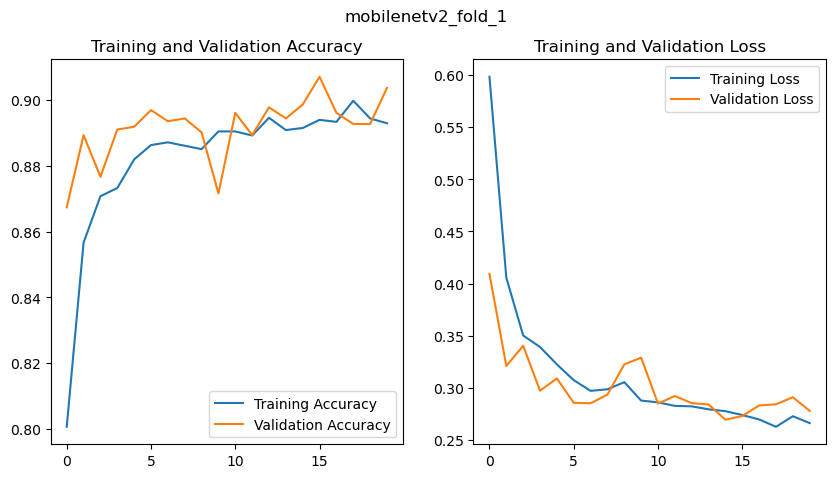

End:2025-03-20_20:33


===== Training Fold 2 of 5 =====
Start:2025-03-20_20:33
Found 4853 validated image filenames belonging to 5 classes.
Found 1214 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_2...
data_maize\data_kfold\savedmodels_mz/mobilenetv2_fold_2_2025_03_20_20_41_29.h5
Model saved to mobilenetv2_fold_2...
Fold 2 complete. Model saved as mobilenetv2_fold_2.h5

Saving mobilenetv2_fold_2 history and parameters...
Saved mobilenetv2_fold_2 history...
Saved mobilenetv2_fold_2 history and parameters...


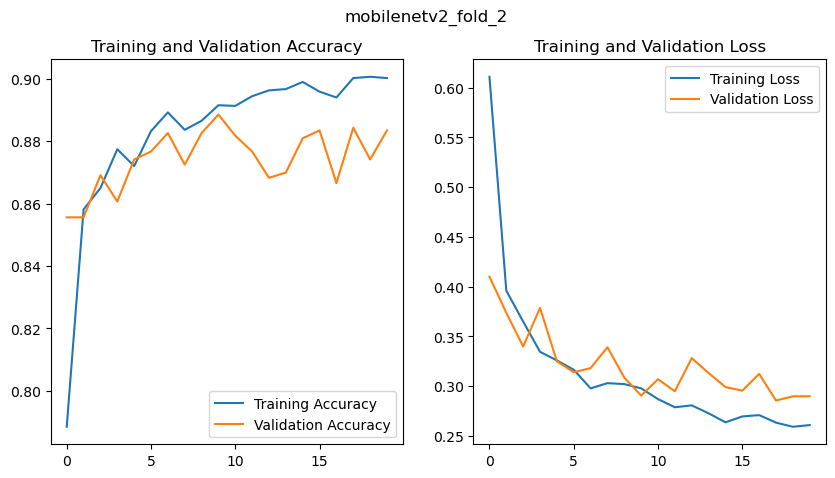

End:2025-03-20_20:41


===== Training Fold 3 of 5 =====
Start:2025-03-20_20:41
Found 4854 validated image filenames belonging to 5 classes.
Found 1213 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_3...
data_maize\data_kfold\savedmodels_mz/mobilenetv2_fold_3_2025_03_20_20_49_13.h5
Model saved to mobilenetv2_fold_3...
Fold 3 complete. Model saved as mobilenetv2_fold_3.h5

Saving mobilenetv2_fold_3 history and parameters...
Saved mobilenetv2_fold_3 history...
Saved mobilenetv2_fold_3 history and parameters...


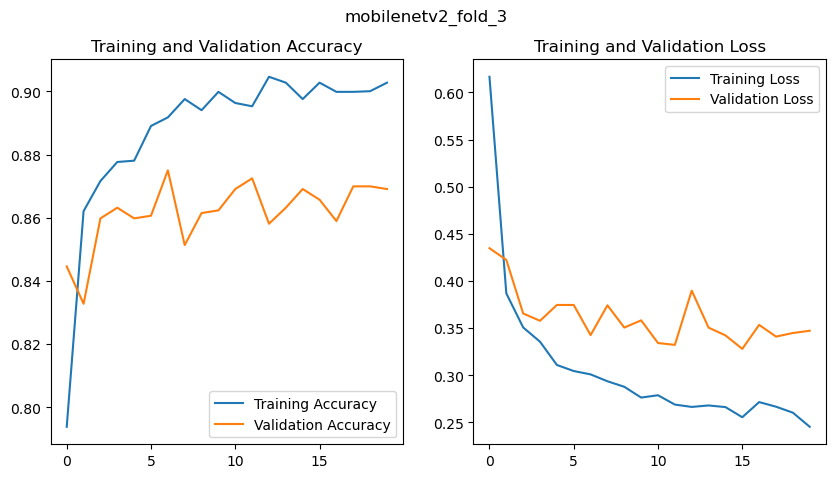

End:2025-03-20_20:49


===== Training Fold 4 of 5 =====
Start:2025-03-20_20:49
Found 4854 validated image filenames belonging to 5 classes.
Found 1213 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_4...
data_maize\data_kfold\savedmodels_mz/mobilenetv2_fold_4_2025_03_20_20_56_57.h5
Model saved to mobilenetv2_fold_4...
Fold 4 complete. Model saved as mobilenetv2_fold_4.h5

Saving mobilenetv2_fold_4 history and parameters...
Saved mobilenetv2_fold_4 history...
Saved mobilenetv2_fold_4 history and parameters...


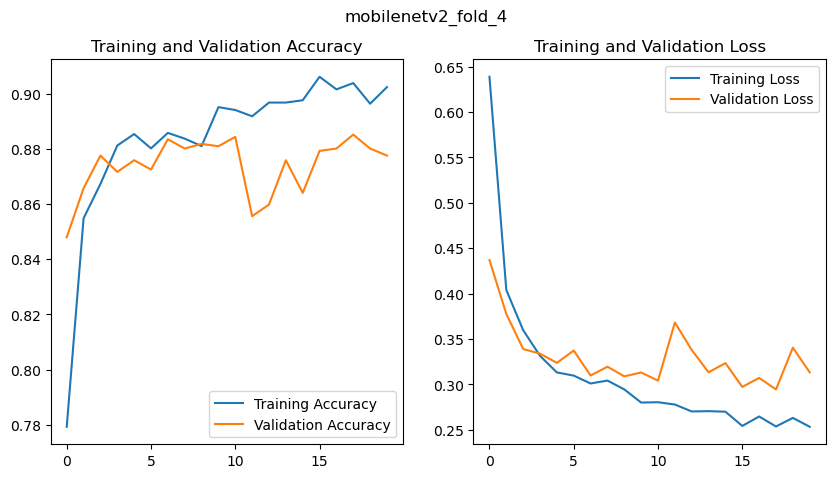

End:2025-03-20_20:56


===== Training Fold 5 of 5 =====
Start:2025-03-20_20:56
Found 4854 validated image filenames belonging to 5 classes.
Found 1213 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_5...
data_maize\data_kfold\savedmodels_mz/mobilenetv2_fold_5_2025_03_20_21_04_58.h5
Model saved to mobilenetv2_fold_5...
Fold 5 complete. Model saved as mobilenetv2_fold_5.h5

Saving mobilenetv2_fold_5 history and parameters...
Saved mobilenetv2_fold_5 history...
Saved mobilenetv2_fold_5 history and parameters...


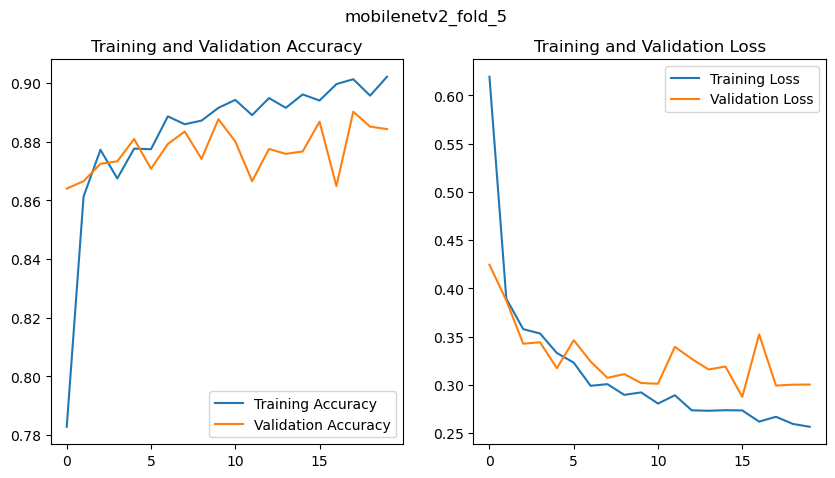

End:2025-03-20_21:04
Total images found: 8058
                                            filename    class
0  data_banana\data_kfold\banana\bs_high\Image_1.jpg  bs_high
1  data_banana\data_kfold\banana\bs_high\Image_10...  bs_high
2  data_banana\data_kfold\banana\bs_high\Image_10...  bs_high
3  data_banana\data_kfold\banana\bs_high\Image_10...  bs_high
4  data_banana\data_kfold\banana\bs_high\Image_10...  bs_high


===== Training Fold 1 of 5 =====
Start:2025-03-20_21:04
Found 6446 validated image filenames belonging to 5 classes.
Found 1612 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_1...
data_banana\data_kfold\savedmodels_ban/mobilenetv2_fold_1_2025_03_20_21_15_55.h5
Model saved to mobilenetv2_fold_1...
Fold 1 complete. Model saved as mobilenetv2_fold_1.h5

Saving mobilenetv2_fold_1 history and parameters...
Saved mobilenetv2_fold_1 history...
Saved mobilenetv2_fold_1 history and parameters...


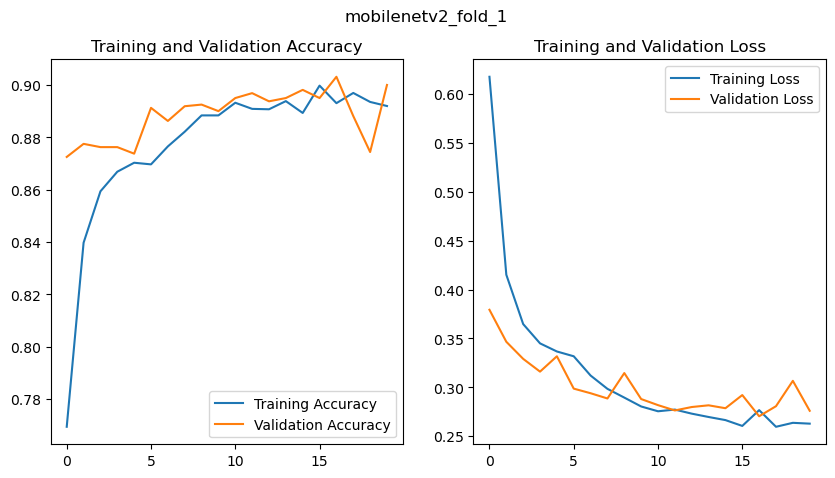

End:2025-03-20_21:15


===== Training Fold 2 of 5 =====
Start:2025-03-20_21:15
Found 6446 validated image filenames belonging to 5 classes.
Found 1612 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_2...
data_banana\data_kfold\savedmodels_ban/mobilenetv2_fold_2_2025_03_20_21_26_50.h5
Model saved to mobilenetv2_fold_2...
Fold 2 complete. Model saved as mobilenetv2_fold_2.h5

Saving mobilenetv2_fold_2 history and parameters...
Saved mobilenetv2_fold_2 history...
Saved mobilenetv2_fold_2 history and parameters...


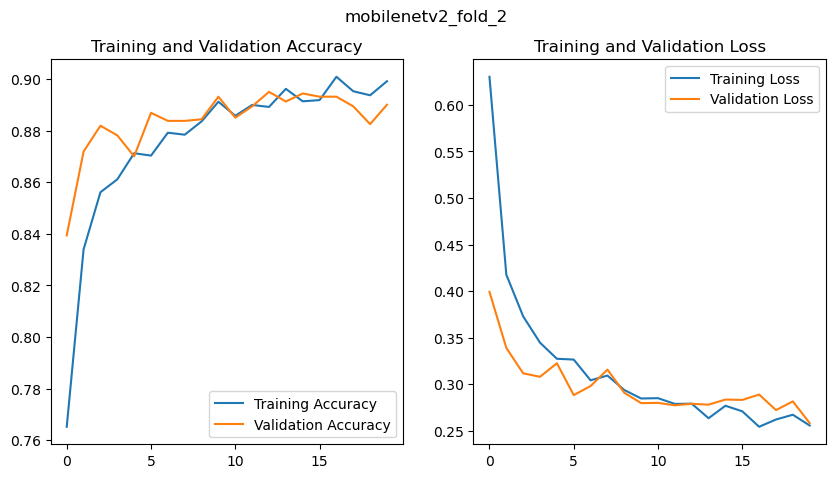

End:2025-03-20_21:26


===== Training Fold 3 of 5 =====
Start:2025-03-20_21:26
Found 6446 validated image filenames belonging to 5 classes.
Found 1612 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_3...
data_banana\data_kfold\savedmodels_ban/mobilenetv2_fold_3_2025_03_20_21_37_37.h5
Model saved to mobilenetv2_fold_3...
Fold 3 complete. Model saved as mobilenetv2_fold_3.h5

Saving mobilenetv2_fold_3 history and parameters...
Saved mobilenetv2_fold_3 history...
Saved mobilenetv2_fold_3 history and parameters...


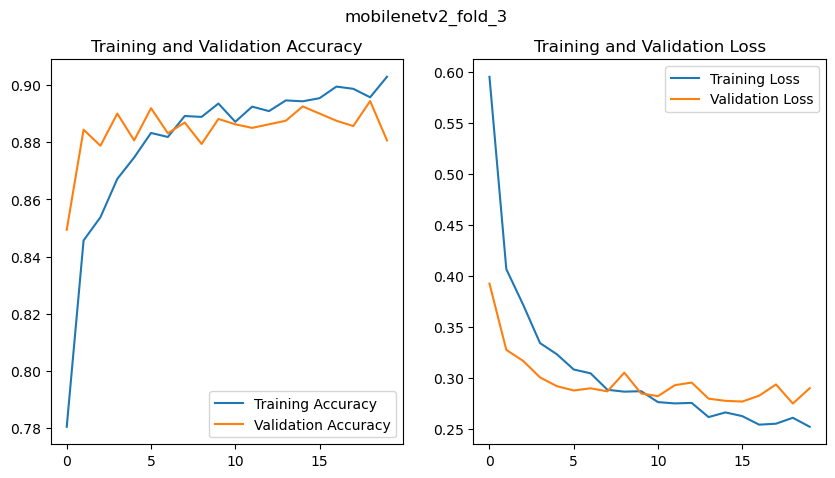

End:2025-03-20_21:37


===== Training Fold 4 of 5 =====
Start:2025-03-20_21:37
Found 6447 validated image filenames belonging to 5 classes.
Found 1611 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_4...
data_banana\data_kfold\savedmodels_ban/mobilenetv2_fold_4_2025_03_20_21_48_34.h5
Model saved to mobilenetv2_fold_4...
Fold 4 complete. Model saved as mobilenetv2_fold_4.h5

Saving mobilenetv2_fold_4 history and parameters...
Saved mobilenetv2_fold_4 history...
Saved mobilenetv2_fold_4 history and parameters...


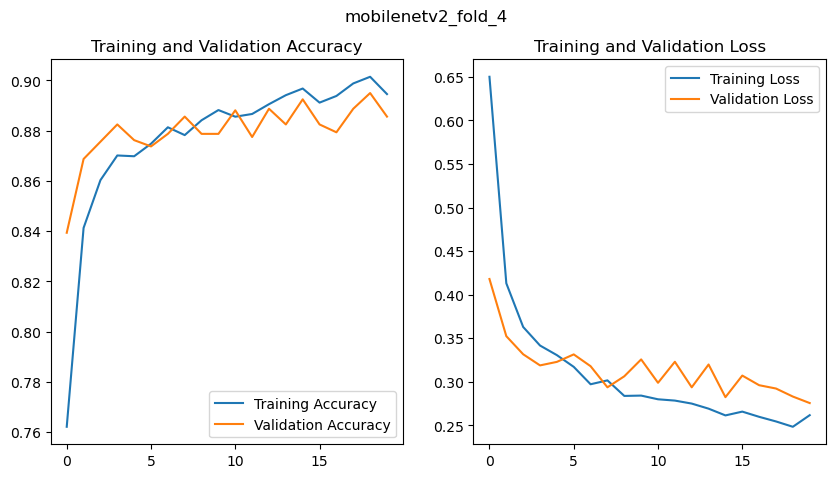

End:2025-03-20_21:48


===== Training Fold 5 of 5 =====
Start:2025-03-20_21:48
Found 6447 validated image filenames belonging to 5 classes.
Found 1611 validated image filenames belonging to 5 classes.
Saving mobilenetv2_fold_5...
data_banana\data_kfold\savedmodels_ban/mobilenetv2_fold_5_2025_03_20_21_59_18.h5
Model saved to mobilenetv2_fold_5...
Fold 5 complete. Model saved as mobilenetv2_fold_5.h5

Saving mobilenetv2_fold_5 history and parameters...
Saved mobilenetv2_fold_5 history...
Saved mobilenetv2_fold_5 history and parameters...


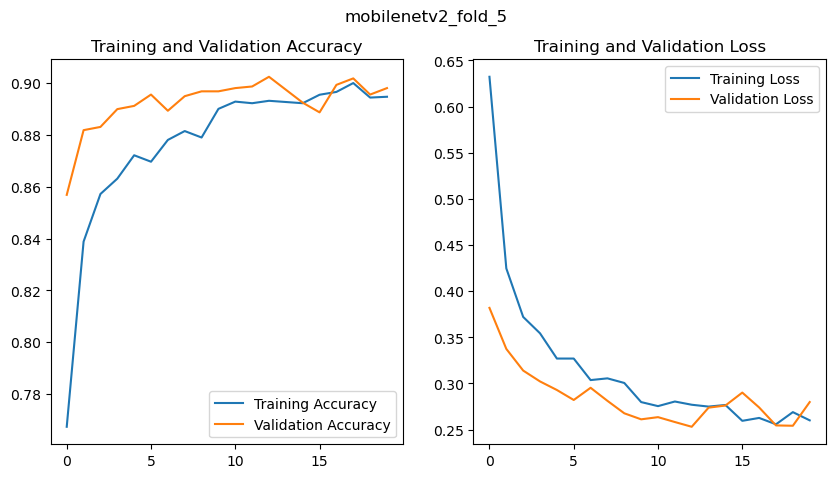

End:2025-03-20_21:59


In [30]:
# -----------------------------
# Set up 5-Fold Cross-validation using StratifiedKFold
# -----------------------------
for config in configs:
    df = build_dataframe(config['base_dir'])
    print(f"Total images found: {len(df)}")
    print(df.head())
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_no = 1
    for train_idx, val_idx in skf.split(df['filename'], df['class']):
        print(f"\n\n===== Training Fold {fold_no} of {n_splits} =====")
        t = datetime.now()
        print(t.strftime(f"Start:%Y-%m-%d_%H:%M"))

        # Split the DataFrame into training and validation folds
        df_train = df.iloc[train_idx].reset_index(drop=True)
        df_val   = df.iloc[val_idx].reset_index(drop=True)

        # Create generators using flow_from_dataframe
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=df_train,
            x_col='filename',
            y_col='class',
            target_size=config['input_shape'][:2],
            batch_size=config['batch_size'],
            class_mode='categorical',
            shuffle=True
        )

        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe=df_val,
            x_col='filename',
            y_col='class',
            target_size=config['input_shape'][:2],
            batch_size=config['batch_size'],
            class_mode='categorical'
        )

        # Build (or reinitialize) the model for this fold
        model = build_kfold_model(config)

        # Train the model
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // config['batch_size'],
            epochs=config['epochs'],
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // config['batch_size'],
            verbose=0
        )

        # Optionally, save the model (or its weights) for this fold
        foldername = config['savedmodels_dir']

        #save the built model in H5 format        
        save_trained_model(model,f'mobilenetv2_fold_{fold_no}', foldername)
        print(f"Fold {fold_no} complete. Model saved as mobilenetv2_fold_{fold_no}.h5\n")


        # Save the history into model's corresponding JSON
        save_history_to_json(history,f'mobilenetv2_fold_{fold_no}',foldername)

        #plot the performance metrics curves
        plot_model_performance_curve(f'mobilenetv2_fold_{fold_no}', history, foldername)

        t = datetime.now()
        print(t.strftime(f"End:%Y-%m-%d_%H:%M"))

        fold_no += 1


## Evaluation of K-Fold Cross Validation Models 
Here 1 out 5 Cross Validated models for both Banana and Maize are tested and see how they perform 

In [34]:
# Configs for cross validated models evaluation
kfold_configs = [
    {
        'name': 'KFold-Banana',
        'path_to_model': 'data_banana\\test_banana\\kfold_best_model_ban.h5',
        # Folder containing 5 subfolders (one per class)         
        'path_to_test_images': 'data_banana\\test_banana\\images',
        'filename':'banana_preds'
    },
    {
        'name': 'KFold-Maize',
        'path_to_model': 'data_maize\\test_maize\\kfold_best_model_mz.h5',        
        # Folder containing 5 subfolders (one per class) 
        'path_to_test_images': 'data_maize\\test_maize\\images',
        'filename':'maize_preds'
    }
]


data_banana\test_banana\kfold_best_model_ban.h5
data_banana\test_banana\images
Found 103 images belonging to 5 classes.
103/103 [==============================] - 1s 8ms/step
KFold-Banana
data_maize\test_maize\mobilenetv2_fold_2_2025_03_18_04_36_00.h5
data_maize\test_maize\images
Found 50 images belonging to 5 classes.
50/50 [==============================] - 1s 5ms/step
KFold-Maize


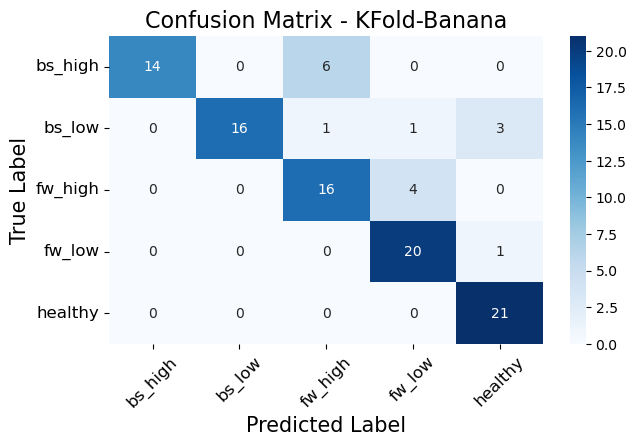

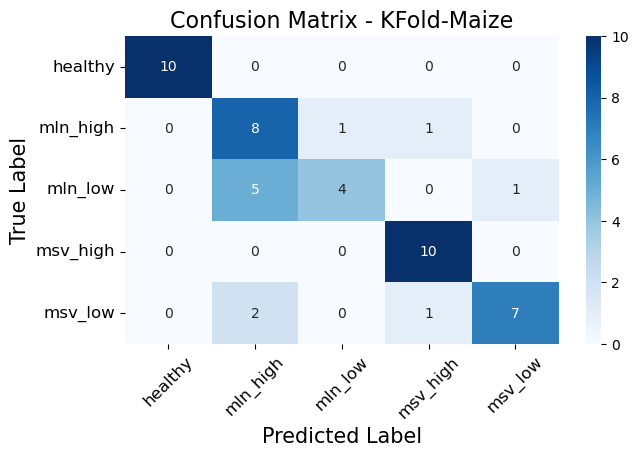

In [35]:
for config in kfold_configs:
    path_to_model = os.path.normpath(config['path_to_model'])
    print(config['path_to_model'])
    # Load the fully trained model
    eval_model = tf.keras.models.load_model(path_to_model)
    
    #path to test images
    test_img_path = os.path.normpath(config['path_to_test_images'])
    print(config['path_to_test_images'])
    # Generator for our testing data, batch = 1 so one image at a time can be tested.
    test_datagen = ImageDataGenerator(rescale=1./255)  
    test_generator = test_datagen.flow_from_directory(
                                                      test_img_path,
                                                      batch_size=1,
                                                      shuffle=False,
                                                      target_size=(224,224), 
                                                      class_mode='categorical')
    # Sanity Check if the model loaded without any errors
    loss, acc, precision, recall = eval_model.evaluate(test_generator)

    eval_model_preds = eval_model.predict(test_generator)
    eval_model_preds_class_indices = np.argmax(eval_model_preds, axis=1)
    # Map indices back to string labels
    # {0: 'bs_high', 1: 'bs_low', 2: 'fw_high', 3: 'fw_low', 4: 'healthy'}
    # bs = Black Sigaitoka, fw = Fusarium Wilt.
    
    class_mapping = {v: k for k, v in test_generator.class_indices.items()}  
    
    # get the predicted results from the model
    eval_model_preds_labels = [class_mapping[idx] for idx in eval_model_preds_class_indices]
    
    #the actual classes 
    true_class_indices = test_generator.classes
    true_class_labels = [class_mapping[i] for i in true_class_indices]
    # correct predictions 
    correct_indices = np.where(eval_model_preds_class_indices == true_class_indices)[0]
    correct_labels = [class_mapping[eval_model_preds_class_indices[i]] for i in correct_indices]
    # incorrect classification
    incorrect_indices = np.where(eval_model_preds_class_indices != true_class_indices)[0]
    incorrect_labels = [class_mapping[true_class_indices[i]] for i in incorrect_indices]
    
    # Save results to CSV
    results = pd.DataFrame({
        'Image Path': test_generator.filepaths,
        'Predicted Label': eval_model_preds_labels,
        'Actual Label' : true_class_labels
    })
    results.to_excel(f'{os.path.dirname(test_img_path)}/{config["filename"]}.xlsx', index=False)
    cm = confusion_matrix(true_class_indices, eval_model_preds_class_indices)
    # [*class_mapping.values()]
    plot_confusion_matrix(cm, list(class_mapping.values()), title=config["name"])
    print(config["name"])

## Pick the BEST MODEL for building FINAL MODEL
This brings to end of training and cross validating the models on `Banana` and `Maize` crops.
### Best Performers
1. Banana : **MobileNetV2-Fold 4** (4th CV iteration)
<table>
<tr><td>Metrics</td><td>Training Average</td><td>Validation Average</td></tr>
<tr><td>Loss</td><td>28.9%</td><td>29.6%</td></tr>
<tr><td>Accuracy</td><td>88.3%</td><td>88.7%</td></tr>
<tr><td>Precision (precision_1)</td><td>89.9%</td><td>89.8%</td></tr>
<tr><td>Recall (recall_1)</td><td>85.5%</td><td>87.7%</td></tr>
<tr><td>F1 Score</td><td>87.6%</td><td>88.7%</td></tr> 
</table>

3. Maize : **MobileNetV2-Fold 2** (2nd CV iteration)
<table>
<tr><td>Metrics</td><td>Training Average</td><td>Validation Average</td></tr>   
<tr><td>Loss</td><td>28.6%</td><td>31.0%</td></tr>
<tr><td>Accuracy</td><td>88.7%</td><td>87.8%</td></tr>
<tr><td>Precision (precision_1)</td><td>90.9%</td><td>90.1%</td></tr>
<tr><td>Recall (recall_1)</td><td>86.4%</td><td>85.5%</td></tr>
<tr><td>F1 Score</td><td>88.6%</td><td>87.7%</td></tr> 
</table>


Now moving on to building the **Final Model** using `entire` dataset and `unseen` crop images to test the peformance of the models

[Final Model Building](03_crop_disease_final_models.ipynb)